# Pix2Pix

In [1]:
!pwd

/tf


### Goals
In this notebook, you will write a generative model based on the paper [*Image-to-Image Translation with Conditional Adversarial Networks*](https://arxiv.org/abs/1611.07004) by Isola et al. 2017, also known as Pix2Pix.

You will be training a model that can convert aerial satellite imagery ("input") into map routes ("output"), as was done in the original paper. Since the architecture for the generator is a U-Net, which you've already implemented (with minor changes), the emphasis of the assignment will be on the loss function. So that you can see outputs more quickly, you'll be able to see your model train starting from a pre-trained checkpoint - but feel free to train it from scratch on your own too.


![pix2pix example](https://drive.google.com/uc?id=1F-oVKBWcd6RaMyP3weGM8wvRtkK6y6i0)


<!-- You will take the segmentations that you generated in the previous assignment and produce photorealistic images. -->

### Learning Objectives
1.   Implement the loss of a Pix2Pix model that differentiates it from a supervised U-Net.
2.   Observe the change in generator priorities as the Pix2Pix generator trains, changing its emphasis from reconstruction to realism.

<!-- When you're done with this assignment, you'll be able to understand much of [*Image-to-Image Translation with Conditional Adversarial Networks*](https://arxiv.org/abs/1611.07004), which introduced Pix2Pix.

You'll be using the same U-Net as in the previous assignment, but you'll write another discriminator and change the loss to make it a GAN. -->

## Getting Started
You will start by importing libraries, defining a visualization function, and getting the pre-trained Pix2Pix checkpoint. You will also be provided with the U-Net code for the Pix2Pix generator.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### U-Net Code

The U-Net code will be much like the code you wrote for the last assignment, but with optional dropout and batchnorm. The structure is changed slightly for Pix2Pix, so that the final image is closer in size to the input image. Feel free to investigate the code if you're interested!

In [2]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)

## PatchGAN Discriminator

Next, you will define a discriminator based on the contracting path of the U-Net to allow you to evaluate the realism of the generated images. Remember that the discriminator outputs a one-channel matrix of classifications instead of a single value. Your discriminator's final layer will simply map from the final number of hidden channels to a single prediction for every pixel of the layer before it.

In [9]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        #### START CODE HERE ####
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)
        #### END CODE HERE ####

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [10]:
# UNIT TEST
test_discriminator = Discriminator(10, 1)
assert tuple(test_discriminator(
    torch.randn(1, 5, 256, 256), 
    torch.randn(1, 5, 256, 256)
).shape) == (1, 1, 16, 16)
print("Success!")

Success!


## Training Preparation
<!-- You'll be using the same U-Net as in the previous assignment, but you'll write another discriminator and change the loss to make it a GAN. -->

Now you can begin putting everything together for training. You start by defining some new parameters as well as the ones you are familiar with:
  *   **real_dim**: the number of channels of the real image and the number expected in the output image
  *   **adv_criterion**: an adversarial loss function to keep track of how well the GAN is fooling the discriminator and how well the discriminator is catching the GAN
  *   **recon_criterion**: a loss function that rewards similar images to the ground truth, which "reconstruct" the image
  *   **lambda_recon**: a parameter for how heavily the reconstruction loss should be weighed
  *   **n_epochs**: the number of times you iterate through the entire dataset when training
  *   **input_dim**: the number of channels of the input image
  *   **display_step**: how often to display/visualize the images
  *   **batch_size**: the number of images per forward/backward pass
  *   **lr**: the learning rate
  *   **target_shape**: the size of the output image (in pixels)
  *   **device**: the device type

In [11]:
import torch.nn.functional as F
# New parameters
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 20
input_dim = 3
real_dim = 3
display_step = 200
batch_size = 4
lr = 0.0002
target_shape = 256
device = 'cuda'

You will then pre-process the images of the dataset to make sure they're all the same size and that the size change due to U-Net layers is accounted for. 

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

import torchvision
dataset = torchvision.datasets.ImageFolder("maps", transform=transform)

Next, you can initialize your generator (U-Net) and discriminator, as well as their optimizers. Finally, you will also load your pre-trained model.

In [13]:
gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
pretrained = True
if pretrained:
    loaded_state = torch.load("pix2pix_15000.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

While there are some changes to the U-Net architecture for Pix2Pix, the most important distinguishing feature of Pix2Pix is its adversarial loss. You will be implementing that here!

In [25]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: get_gen_loss
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. maps) to be used to evaluate the reconstruction
        condition: the source images (e.g. satellite imagery) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the true labels and returns a adversarial 
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator 
                    outputs and the real images and returns a reconstructuion 
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    # Steps: 1) Generate the fake images, based on the conditions.
    #        2) Evaluate the fake images and the condition with the discriminator.
    #        3) Calculate the adversarial and reconstruction losses.
    #        4) Add the two losses, weighting the reconstruction loss appropriately.
    #### START CODE HERE ####
    fake = gen(condition)
    fake_pred = disc(fake, condition)
    adv_loss = adv_criterion(fake_pred, torch.ones_like(fake_pred))
    recon_loss = recon_criterion(fake, real)
    gen_loss = recon_loss * lambda_recon + adv_loss
    #### END CODE HERE ####
    return gen_loss

In [26]:
# UNIT TEST
def test_gen_reasonable(num_images=10):
    gen = torch.zeros_like
    disc = lambda x, y: torch.ones(len(x), 1)
    real = None
    condition = torch.ones(num_images, 3, 10, 10)
    adv_criterion = torch.mul
    recon_criterion = lambda x, y: torch.tensor(0)
    lambda_recon = 0
    assert get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon).sum() == num_images

    disc = lambda x, y: torch.zeros(len(x), 1)
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)).sum() == 0

    adv_criterion = lambda x, y: torch.tensor(0)
    recon_criterion = lambda x, y: torch.abs(x - y).max()
    real = torch.randn(num_images, 3, 10, 10)
    lambda_recon = 2
    gen = lambda x: real + 1
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 2) < 1e-4

    adv_criterion = lambda x, y: (x + y).max() + x.max()
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 3) < 1e-4
test_gen_reasonable()
print("Success!")

Success!


## Pix2Pix Training

Finally, you can train the model and see some of your maps!

Pretrained initial state


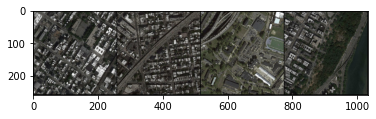

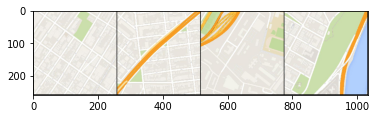

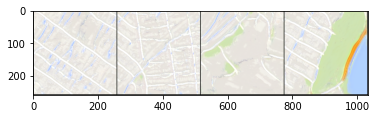

Epoch 0: Step 200: Generator (U-Net) loss: 13.482195959091191, Discriminator loss: 0.13598026552237574


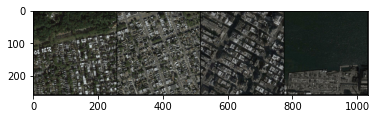

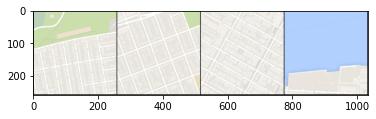

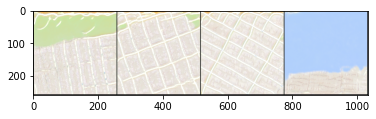

Epoch 0: Step 400: Generator (U-Net) loss: 12.995182356834407, Discriminator loss: 0.17048647827934477


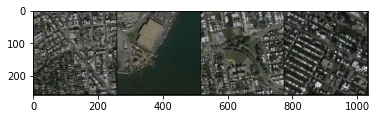

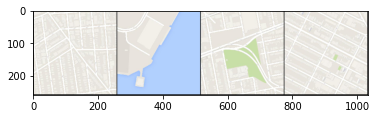

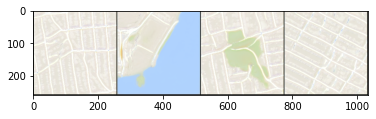

Epoch 1: Step 600: Generator (U-Net) loss: 12.47969104766846, Discriminator loss: 0.1512331999186427


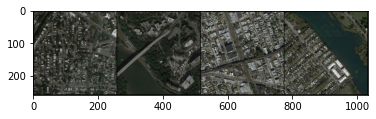

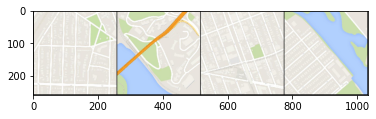

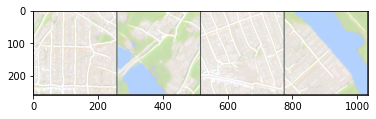

Epoch 1: Step 800: Generator (U-Net) loss: 12.747323718070986, Discriminator loss: 0.13636160579975698


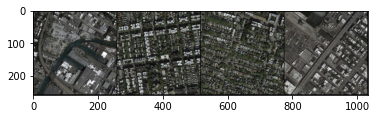

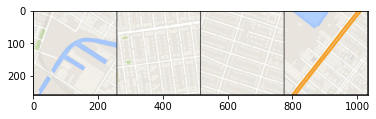

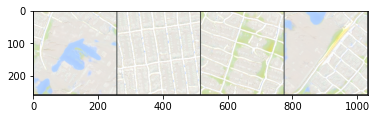

Epoch 1: Step 1000: Generator (U-Net) loss: 12.250625553131107, Discriminator loss: 0.18602299612946807


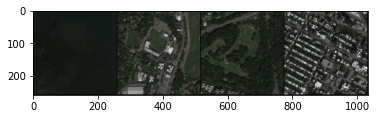

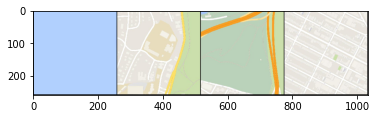

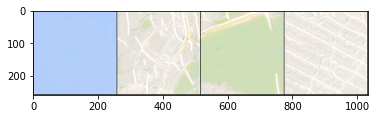

Epoch 2: Step 1200: Generator (U-Net) loss: 12.34871657848358, Discriminator loss: 0.20387550566112633


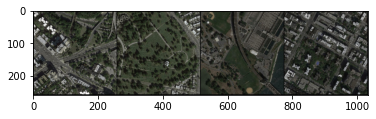

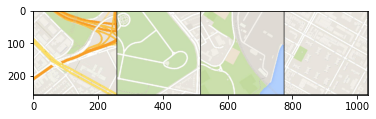

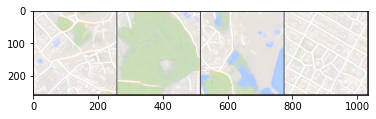

In [ ]:
from skimage import color
import numpy as np

def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(dataloader):
            image_width = image.shape[3]
            condition = image[:, :, :, :image_width // 2]
            condition = nn.functional.interpolate(condition, size=target_shape)
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size=target_shape)
            cur_batch_size = len(condition)
            condition = condition.to(device)
            real = real.to(device)

            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake = gen(condition)
            disc_fake_hat = disc(fake.detach(), condition) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            disc_real_hat = disc(real, condition)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True) # Update gradients
            disc_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images(condition, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(real_dim, target_shape, target_shape))
                show_tensor_images(fake, size=(real_dim, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({'gen': gen.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc': disc.state_dict(),
                        'disc_opt': disc_opt.state_dict()
                    }, f"pix2pix_{cur_step}.pth")
            cur_step += 1
train()